In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
from gpflow.utilities import print_summary

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [456]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [536]:
x_subsample = x.final.b_nn_corrected[::25][560:]
time_subsample = x.base_signals.t_b_nn[::25][560:]

mean = np.mean(x_subsample)
std = np.std(x_subsample)

mean_t = np.mean(time_subsample)
std_t = np.std(time_subsample)

X, Y = (time_subsample - mean_t)/std_t, (x_subsample - mean)/std
X, Y = X[np.greater_equal(Y, -5)],  Y[np.greater_equal(Y, -5)]
X, Y = X[np.less_equal(Y, 5)],  Y[np.less_equal(Y, 5)]
X, Y = X.reshape(-1,1), Y.reshape(-1,1)

N = np.size(X)

In [537]:
X.shape

(1004, 1)

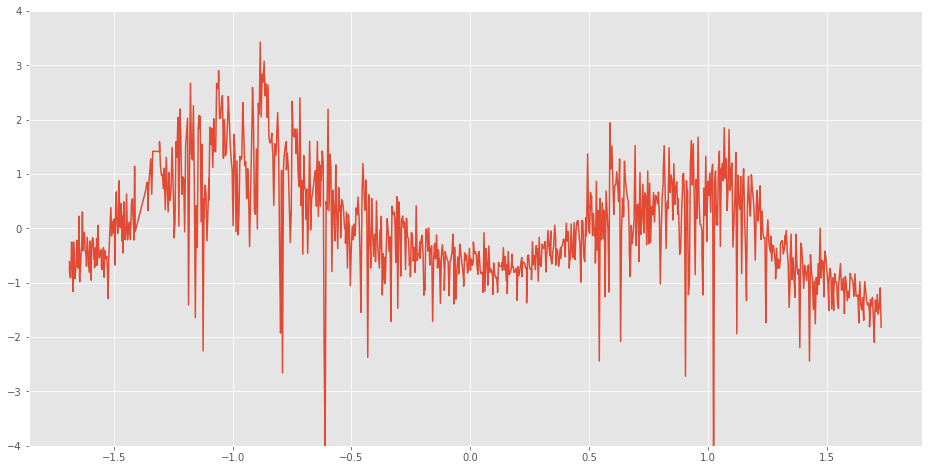

In [538]:
plt.figure(5, figsize=(16, 8))
plt.ylim(-4, 4)
plt.plot(X, Y)

In [540]:
N=160
interval = (np.min(X), np.max(X))
time_indicies=np.linspace(interval[0], interval[1], N)

In [541]:
def find_nearest(array, values):
    indices = np.zeros(values.shape)
    for index, value in enumerate(values):
        indices[index] = np.abs(array - value).argmin()
    return indices

In [542]:
np.size(find_nearest(X, time_indicies).astype(int))

160

In [544]:
indices = find_nearest(X, time_indicies).astype(int)

kernel = gpflow.kernels.Sum([gpflow.kernels.Matern32(),gpflow.kernels.White()])
Z = X[indices].copy()  # Initialise inducing locations
M = np.size(Z)
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
m.kernel.kernels[0].lengthscale.assign(0.143)
#m.kernel.kernels[0].variance.assign(1)
#gpflow.utilities.set_trainable(m.kernel.kernels[0].variance, False)


#m.kernel.kernels[1].variance.assign(0.288)

#gpflow.utilities.set_trainable(m.kernel.kernels[0].lengthscale, False)

print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  0.1430000066757202
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z            Parameter                  True         (160, 1)       float64  [[-1.68638542...
SVGP.q_mu                           Parameter                  True         (160, 1)       float64  [[0....
SVGP.q_sqrt                         Parameter  FillTriangular  True         (1, 160, 160)  float64  [[[1., 0., 0....


In [545]:
indices

array([   0,   10,   19,   28,   34,   44,   52,   62,   70,   80,   88,
         98,  104,  111,  112,  112,  117,  120,  123,  129,  136,  142,
        148,  154,  160,  166,  172,  178,  185,  191,  197,  203,  210,
        217,  223,  230,  236,  242,  248,  255,  261,  267,  273,  280,
        286,  292,  299,  305,  310,  316,  323,  329,  335,  341,  348,
        354,  361,  367,  372,  379,  385,  392,  397,  403,  409,  416,
        422,  428,  434,  441,  447,  453,  460,  466,  472,  478,  485,
        491,  497,  503,  510,  516,  523,  530,  536,  542,  548,  555,
        561,  567,  573,  580,  586,  592,  598,  605,  611,  617,  624,
        630,  635,  641,  648,  654,  661,  667,  673,  679,  685,  691,
        697,  703,  709,  716,  722,  728,  734,  741,  747,  753,  759,
        766,  773,  779,  786,  792,  798,  804,  811,  817,  823,  828,
        835,  841,  847,  854,  860,  866,  872,  879,  885,  891,  897,
        904,  910,  917,  923,  930,  936,  942,  9

In [546]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [547]:
%%timeit
log_likelihood(X, Y)

6.29 ms ± 97 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [548]:
minibatch_size = 200

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [549]:
%%timeit
log_likelihood(*next(train_it))

2.96 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [550]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: 0.22666400992454783


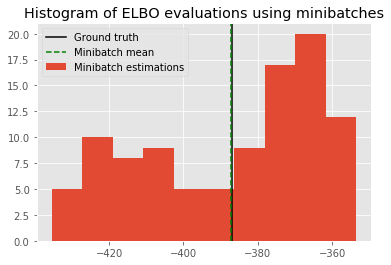

In [551]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [552]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

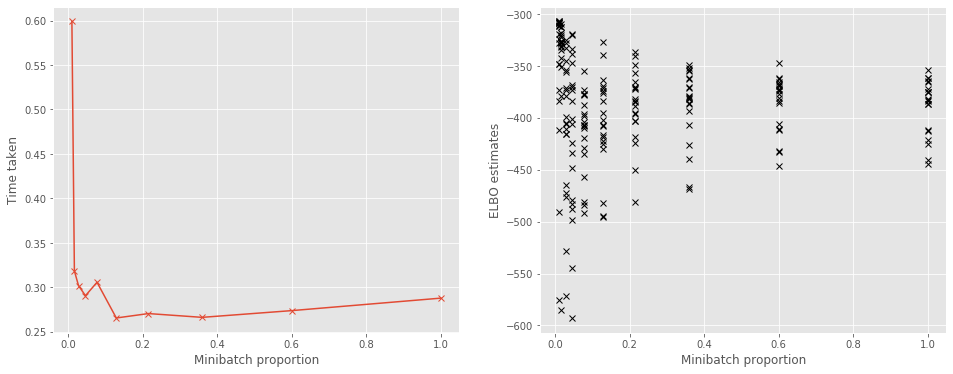

In [553]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(160, 1)


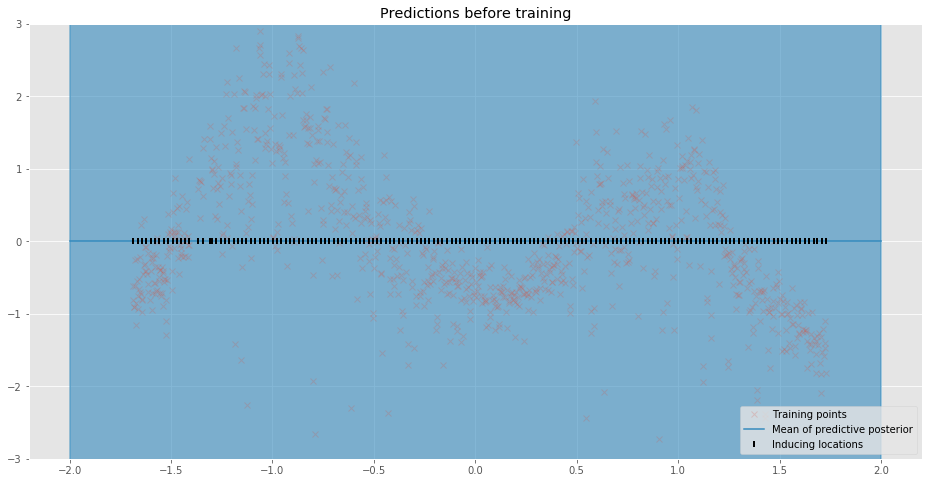

In [554]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(-2, 2, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    plt.ylim(-3, 3)

plot(title="Predictions before training")

In [555]:
minibatch_size = 100

# We turn of training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
We are on the step 1000
We are on the step 2000
We are on the step 3000
We are on the step 4000
We are on the step 5000
We are on the step 6000
We are on the step 7000
47.79584503173828


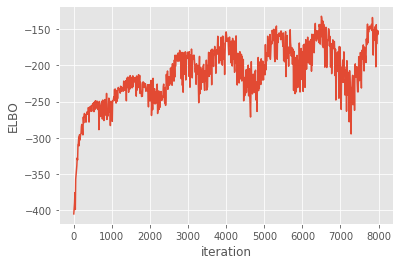

In [556]:
start = time.time()

maxiter = ci_niter(8000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

(160, 1)


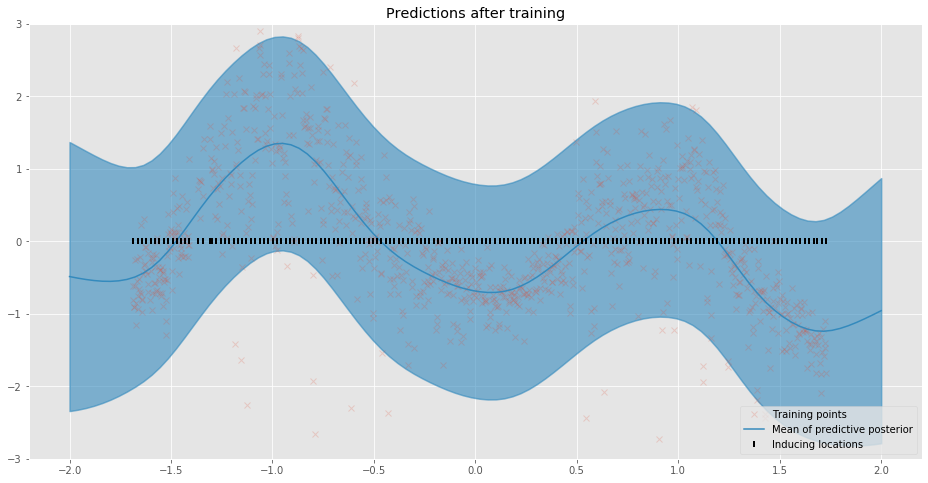

In [557]:
plot("Predictions after training")

In [558]:
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.6251607444080344
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  0.556988268843489
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  0.01027862218792053
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  0.501341044464468
SVGP.inducing_variable.Z            Parameter                  False        (160, 1)       float64  [[-1.68638542...
SVGP.q_mu                           Parameter                  True         (160, 1)       float64  [[-6.25024414e-01...
SVGP.q_sqrt                 

AttributeError: 'Gaussian' object has no attribute 'likelihood'

# Kernel Design

In [1]:
from gpflow.utilities import print_summary, positive
from gpflow.utilities.ops import square_distance

In [167]:
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')
import time
import pickle
from gpflow.utilities import print_summary

with open('./results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [168]:
x_subsample_a = x.final.a_nn_corrected[::10000]
time_subsample_a = x.base_signals.t_a_nn[::10000]

x_subsample_b = x.final.b_nn_corrected[::30][500:]
time_subsample_b = x.base_signals.t_b_nn[::30][500:]

mean = np.mean(np.concatenate((x_subsample_a, x_subsample_b)))
std = np.std(np.concatenate((x_subsample_a, x_subsample_b)))

mean_t = np.mean(np.concatenate((time_subsample_a, time_subsample_b)))
std_t = np.std(np.concatenate((time_subsample_a, time_subsample_b)))

X_a, Y_a = (time_subsample_a - mean_t)/std_t, (x_subsample_a - mean)/std
X_a, Y_a = X_a[np.greater_equal(Y_a, -4)],  Y_a[np.greater_equal(Y_a, -4)]
X_a, Y_a = X_a[np.less_equal(Y_a, 4)],  Y_a[np.less_equal(Y_a, 4)]
X_a = np.stack((X_a, np.ones(X_a.shape)))

X_b, Y_b = (time_subsample_b - mean_t)/std_t, (x_subsample_b - mean)/std
X_b, Y_b = X_b[np.greater_equal(Y_b, -4)],  Y_b[np.greater_equal(Y_b, -4)]
X_b, Y_b = X_b[np.less_equal(Y_b, 4)],  Y_b[np.less_equal(Y_b, 4)]
X_b = np.stack((X_b, np.zeros(X_b.shape)))

print(X_a.shape, Y_a.shape, X_b.shape, Y_b.shape)

(2, 1162) (1162,) (2, 802) (802,)


In [169]:
X = np.transpose(np.concatenate((X_a, X_b), axis=1)).reshape(-1, 2)
Y = np.transpose(np.concatenate((Y_a, Y_b), axis=0)).reshape(-1, 1)

print(X.shape, Y.shape)
N=np.size(Y)

Z = X[::30,:].copy()  # Initialise inducing locations
print(Z.shape)

(1964, 2) (1964, 1)
(66, 2)


0.00611315189046515 -0.0001751342616411631


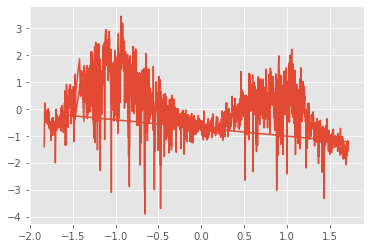

In [171]:
print(np.mean(Y), np.mean(X[:,0]))
plt.plot(X[:,0], Y)

In [173]:
class VirgoMatern32Kernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.variance = gpflow.Parameter(1.0, transform=positive())
        self.lengthscale = gpflow.Parameter(1.0, transform=positive())
        
    def scaled_squared_euclid_dist(self, X, X2=None):
        """
        Returns ||(X - X2ᵀ) / ℓ||² i.e. squared L2-norm.
        """
        X_scaled = X / self.lengthscale
        X2_scaled = X2 / self.lengthscale if X2 is not None else X2
        return square_distance(X_scaled, X2_scaled)

    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self.slice(X, X2)
        X = tf.reshape(X[:, 0], [-1, 1])
        X2 = tf.reshape(X2[:, 0], [-1, 1])
        r2 = self.scaled_squared_euclid_dist(X, X2)
        k = self.K_r2(r2)
        #print("K", k.shape)
        return k

    def K_diag(self, X, presliced=False):
        k_diag = tf.fill((X.shape[0], ), tf.squeeze(self.variance))
        #print("K_diag", k_diag.shape)
        return k_diag
        
    def K_r2(self, r):
        sqrt3 = np.sqrt(3.)
        return self.variance * (1. + sqrt3 * r) * tf.exp(-sqrt3 * r)

In [174]:
class VirgoWhiteKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=[0])
        self.variance_a = gpflow.Parameter(1.0, transform=positive())
        self.variance_b = gpflow.Parameter(1.0, transform=positive())
        
    def K(self, X, X2=None, presliced=None):
        if X2 is None:
            d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
            d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_b))
            indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
            indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
            a=tf.linalg.diag(tf.multiply(d_a, indices_a) + tf.multiply(d_b, indices_b))
            #print(a.shape)
            return a
        else:
            shape = [X.shape[0], X2.shape[0]]
            #print(shape)
            return tf.zeros(shape, dtype=X.dtype)

    def K_diag(self, X, presliced=None):
        d_a = tf.fill((X.shape[0], ), tf.squeeze(self.variance_a))
        d_b = tf.fill((X.shape[0], ), tf.squeeze(self.variance_b))
        indices_a = tf.cast(tf.equal(X[:,1], 0), dtype=tf.float64)
        indices_b = tf.cast(tf.equal(X[:,1], 1), dtype=tf.float64)
        a = tf.multiply(d_a, indices_a) + tf.multiply(d_b, indices_b)
        #print(a.shape)
        return a

# Training Gaussian Processes on both A) and B) signal

In [175]:
N=150
interval = (np.min(X[:,0]), np.max(X[:,0]))
time_indicies=np.linspace(interval[0], interval[1], N)

In [179]:
#time_indicies

In [180]:
def find_nearest(array, values):
    indices = np.zeros(values.shape)
    for index, value in enumerate(values):
        indices[index] = np.abs(array - value).argmin()
    return indices

In [181]:
indices = find_nearest(X[:,0], time_indicies).astype(int)
Z = X[indices,:]

In [182]:
N = Z.shape[0]

In [186]:
kernel = gpflow.kernels.Sum([VirgoMatern32Kernel(), VirgoWhiteKernel()])
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)
m.kernel.kernels[0].lengthscale.assign(427)
# m.kernel.kernels[0].variance.assign(0.004)
# m.kernel.kernels[1].variance_a.assign(0.005)
# m.kernel.kernels[1].variance_b.assign(0.004)

gpflow.utilities.set_trainable(m.inducing_variable, False)
#gpflow.utilities.set_trainable(m.kernel.kernels[0].lengthscale, False)

print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  427.0
SVGP.kernel.kernels[1].variance_a   Parameter  Softplus        True         ()             float64  1.0
SVGP.kernel.kernels[1].variance_b   Parameter  Softplus        True         ()             float64  1.0
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0
SVGP.inducing_variable.Z            Parameter                  False        (150, 2)       float64  [[-1.83497425e+00, 1.00000000e+00...
SVGP.q_mu                           Parameter                  True         (150, 1)       float64

In [187]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [188]:
%%timeit
log_likelihood(X, Y)

12.1 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [189]:
#m.trainable_variables

In [190]:
m.kernel.kernels[1].variance_a

<tf.Tensor: id=146769, shape=(), dtype=float64, numpy=1.0>

In [191]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(X, Y).numpy()

In [192]:
%%timeit
log_likelihood(*next(train_it))

2.22 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [193]:
evals = [log_likelihood(*minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: -0.1455955015728705


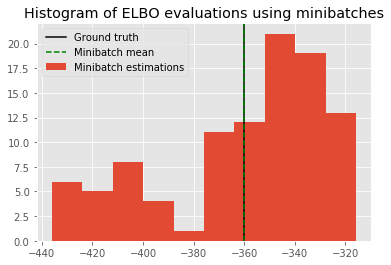

In [194]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

In [195]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(*minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

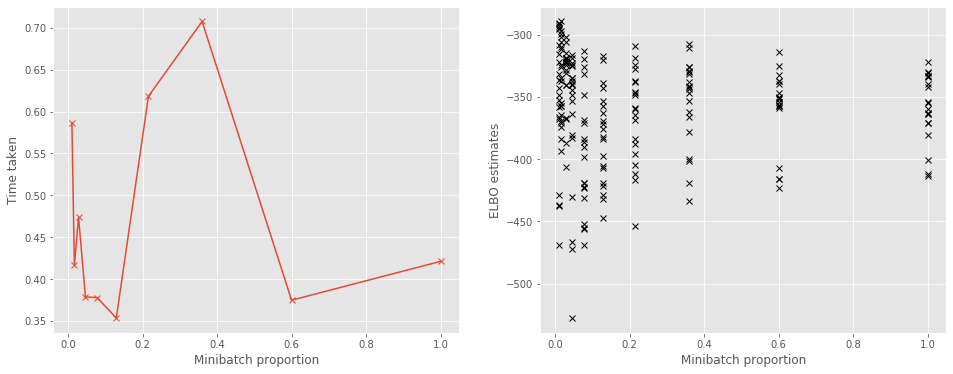

In [196]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

(150, 2)


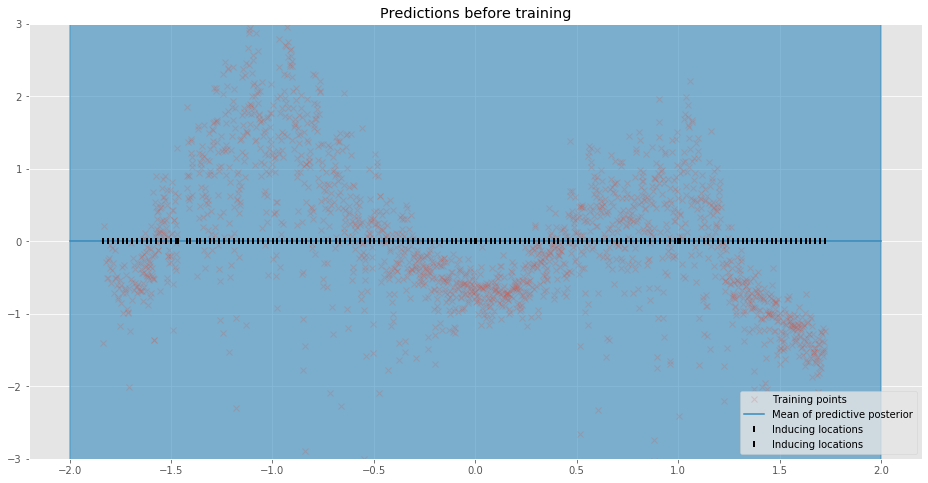

In [198]:
def plot(title=''):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    pX = np.linspace(-2, 2, 100)  # Test locations
    pX = np.transpose(np.stack((pX, 0*np.ones(100))))
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X[:,0], Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX[:,0], pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    print(Z.shape)
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')
    plt.ylim(-3, 3)

plot(title="Predictions before training")

In [199]:
print(m.inducing_variable.trainable_variables)

()


In [200]:
minibatch_size = 200

# We turn of training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(*batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimiser
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        if step % 1000 == 0:
            print('We are on the step {}'.format(step))
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

We are on the step 0
We are on the step 1000
We are on the step 2000
We are on the step 3000
We are on the step 4000
We are on the step 5000
We are on the step 6000
We are on the step 7000
54.449471950531006


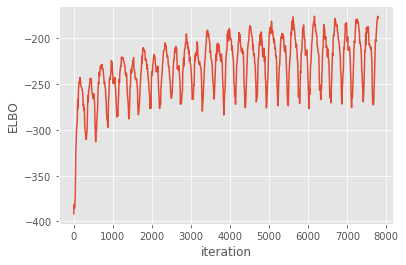

In [201]:
start = time.time()

maxiter = ci_niter(7800)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

end = time.time()
print(end - start)

In [28]:
m.kernel.kernels[0].lengthscale.assign(427)

(150, 2)


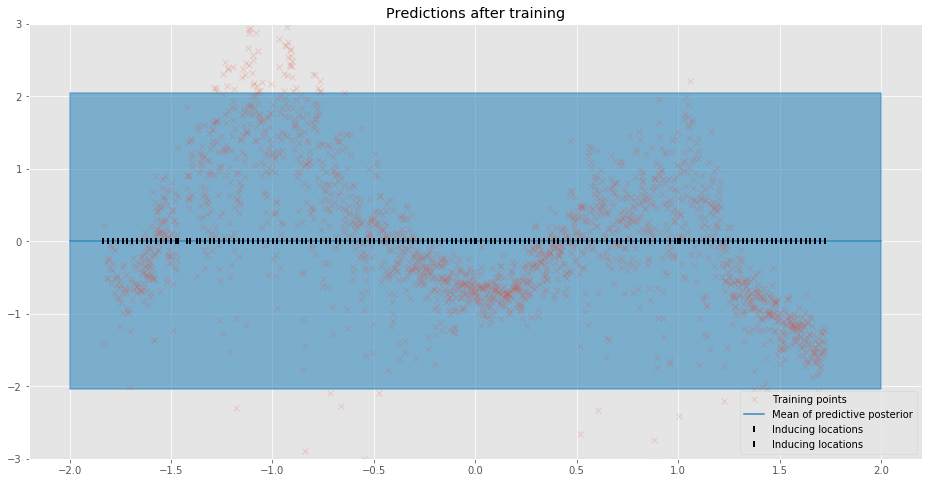

In [202]:
plot("Predictions after training")

In [203]:
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.07438333532822686
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  427.00635345841545
SVGP.kernel.kernels[1].variance_a   Parameter  Softplus        True         ()             float64  0.03497597270703369
SVGP.kernel.kernels[1].variance_b   Parameter  Softplus        True         ()             float64  0.024344883790573108
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  1.0072066244548805
SVGP.inducing_variable.Z            Parameter                  False        (150, 2)       float64  [[-1.83497425e+00, 1.00000000e+00...
SVGP.

In [79]:
#summary for model b
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.09109494566793845
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  434.2123198973774
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  0.004988013369871379
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  0.13445917822574976
SVGP.inducing_variable.Z            Parameter                  False        (150, 1)       float64  [[498.119...
SVGP.q_mu                           Parameter                  True         (150, 1)       float64  [[-0.46997968...
SVGP.q_sqrt                     

In [102]:
# summary for model a
print_summary(m)

name                                class      transform       trainable    shape          dtype    value
----------------------------------  ---------  --------------  -----------  -------------  -------  ----------------------------------------------------
SVGP.kernel.kernels[0].variance     Parameter  Softplus        True         ()             float64  0.07984570030402384
SVGP.kernel.kernels[0].lengthscale  Parameter  Softplus        True         ()             float64  434.15559787678256
SVGP.kernel.kernels[1].variance     Parameter  Softplus        True         ()             float64  0.0050049366473623414
SVGP.likelihood.variance            Parameter  Softplus        True         ()             float64  0.13553143430097475
SVGP.inducing_variable.Z            Parameter                  False        (150, 1)       float64  [[48.026...
SVGP.q_mu                           Parameter                  True         (150, 1)       float64  [[-0.65892516...
SVGP.q_sqrt                    